In [45]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import glob
import pandas as pd
from itertools import islice

import sys
import time
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

from build_features import similarity_matrix, name_cleaner, yield_chunks
from transformers import DistilBertTokenizer, DistilBertModel

%matplotlib inline

## Load data

In [ ]:
root = "../data/processed/"
datadict = {}
# Load the pickle list
data_files = glob.glob(root+ 'descriptions*PLANTS.pkl')
for data_file in data_files:
    # Open the dict and update
    datadict.update(pickle.load(open(data_file, 'rb')))

In [ ]:
subset = pickle.load(open('../data/processed/subset_NLP_model.pkl', 'rb'))

#### Drop double Sentences

In [ ]:
data_dissimilar = collections.defaultdict(list)

# Drop double sentences
for key, values in tqdm(datadict.items()):
    # Drop URLS
    values = [sent for (sent, URL) in values]
    # Get similarity matrix
    matrix = similarity_matrix(values)
    # Extract indices with threshold
    indices = np.transpose((matrix>0.99).nonzero())
    # Get doubles
    if len(indices) > 1:
        doubles = [values[idx_y] for (idx_x, idx_y) in indices if idx_x != idx_y]
        # drop last half of list
        doubles = doubles[len(doubles)//2:]
        # sentences non double
        sents_nodouble = [sent for sent in values if sent not in doubles]
        # Replace data
        data_dissimilar[key] = sents_nodouble

In [ ]:
subset

## Visualisation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

##### Descriptions per Species

In [ ]:
# Change this to the dissimilar in future
counts = [len(sents) for key, sents in subset.items()]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
ax = sns.histplot(counts)
ax.set_title('Histogram')
plt.xlim(0, 300)

##### Sentence Similarity

In [ ]:
sents = [sent for (sent, URL) in datadict['Abies araucana']]
#max_key, max_value = max(data.items(), key = lambda x: len(set(x[1])))

In [ ]:
re.sub(r'(\s*\.){1,}', '.', 'This is a test.. .')

In [121]:
sents = [
    'The European robin has a orange plumage.',
    'Black bill, plumage orange.',
    'The bear is large and the claws are sharp.',
    'Bill black; plumage orange.',
    'The bill is black and the plumage is orange.',
    'The bear is large, and the claws are sharp.'
]

In [122]:
matrix = similarity_matrix(sents)

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

# Delete empty rows and columns
matrix = np.delete(matrix, (0), axis=0)
mask = np.delete(mask, (0), axis=0)
matrix = np.delete(matrix, (-1), axis=1)
mask = np.delete(mask, (-1), axis=1)

In [123]:
df = pd.DataFrame(matrix)
df.index = sents[1:]
df.columns = sents[:-1]

In [124]:
df

,The European robin has a orange plumage.,"Black bill, plumage orange.",The bear is large and the claws are sharp.,Bill black; plumage orange.,The bill is black and the plumage is orange.
"Black bill, plumage orange.",0.86648,1.00000,0.76615,0.98391,0.91962
The bear is large and the claws are sharp.,0.77856,0.76615,1.00000,0.74342,0.78927
Bill black; plumage orange.,0.85398,0.98391,0.74342,1.00000,0.91968
The bill is black and the plumage is orange.,0.91091,0.91962,0.78927,0.91968,1.00000
"The bear is large, and the claws are sharp.",0.77482,0.75742,0.99685,0.73376,0.78198


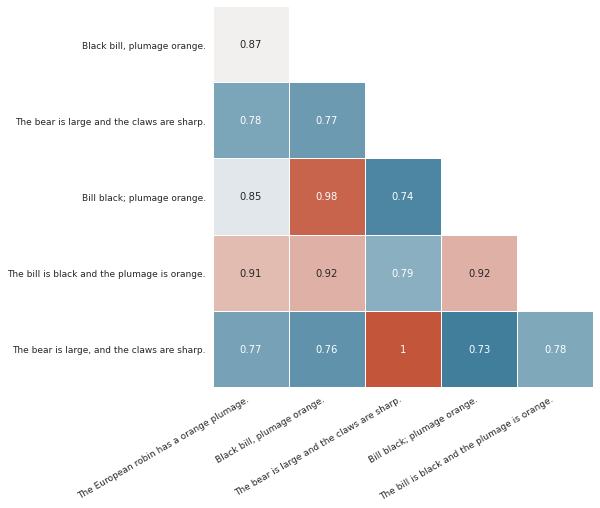

In [128]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(df, 
                     mask=mask, 
                     square=True,
                     annot=True,
                     cbar=False,
                     #cmap='Spectral_r', 
                     cmap=cmap,
                     linewidths=.5,)
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=9)

#f.suptitle('Similarity Matrix', fontsize=13)
f.savefig('similarity_matrix.svg', format='svg', dpi=1200, bbox_inches='tight')